# EARTHQUAKE TWEETS CLASSIFICATION

This notebook composes the first step of my final project for JEDHA bootcamp: developing an app that visualizes emergency calls tweets on a map during the earthquake.

I ran the notebook on Google Colab since the final part requires using GPU and my local computer did not have one. Final step on deployment on huggingface hence involves steps to deploy a model from Colab notebook to a huggingface repository.

### Install and Import Necessary Packages


In [1]:
#!pip install transformers datasets

In [2]:
#!pip install transformers[torch]

In [3]:
#!pip install torch

In [4]:
#!pip install torchinfo

In [5]:
#!pip install huggingface_hub

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import json
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional

from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

from datasets import load_dataset
from transformers import AutoTokenizer, pipeline
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torchinfo import summary

import huggingface_hub

2023-11-30 16:55:19.087907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yagmuraslan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yagmuraslan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## PART 1: EDA & TEXT PREPROCESSING

The dataset I manually annotated on doccano is in json format. Let's upload it.

In [9]:
df = pd.read_json('earthquake10K.json')
df.head()

,id,text,index,label,Comments
0,46001,Arama Kurtarma ekipleri heryere yetişemiyor kı...,108332,[Other],[]
1,46002,"Marketleri, dükkanları, ölmüş insanları yağmal...",66352,[Other],[]
2,46003,Arkadaşlar böyle bir uygulama varmış. İlaçları...,32462,[Other],[]
3,46004,Adıyamanda destek yok. Çok fazla bina yıkıldı ...,84613,[Other],[]
4,46005,"Turunçlu mahallesi samandag yolu uzeri, saray ...",22536,[Rescue_call],[]


In [10]:
for i in range(len(df)):
    a = df['label'][i][0]
    df.loc[i, 'label'] = a

df.head()

,id,text,index,label,Comments
0,46001,Arama Kurtarma ekipleri heryere yetişemiyor kı...,108332,Other,[]
1,46002,"Marketleri, dükkanları, ölmüş insanları yağmal...",66352,Other,[]
2,46003,Arkadaşlar böyle bir uygulama varmış. İlaçları...,32462,Other,[]
3,46004,Adıyamanda destek yok. Çok fazla bina yıkıldı ...,84613,Other,[]
4,46005,"Turunçlu mahallesi samandag yolu uzeri, saray ...",22536,Rescue_call,[]


### Exploring the Data

In [19]:
print("The annotated dataset contains", df.shape[0], 'tweets.')

The annotated dataset contains 10000 tweets.


I had initially annotated the data in three categories:
- rescue calls (belong to calls by or for people who are under the rubbles at the time)
- urgent needs (urgent food, heating, clothing demands)
- other

However, having seen the quite imbalanced distributions of the categories, I decided to merge the first two labels into a single one, to denote all sorts of emergency calls.

<AxesSubplot:>

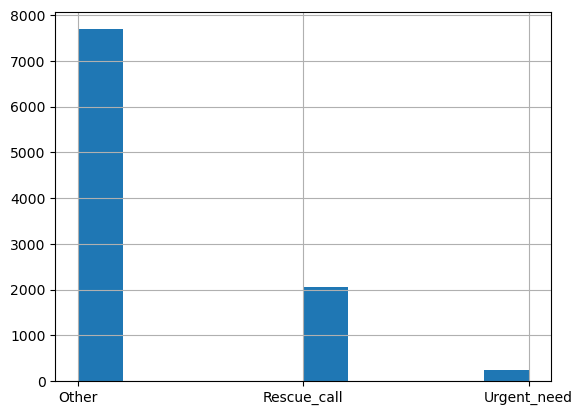

In [11]:
# i annotated the data with three labels yet there is very low occurence for the urgent needs:
df['label'].hist()

In [12]:
def merge_urgents(x):
    if x == 'Urgent_need' or x == 'Rescue_call':
        return 'emergency_call'
    else:
        return x
df['label'] = df['label'].apply(lambda x : merge_urgents(x))
set(df['label'])

{'Other', 'emergency_call'}

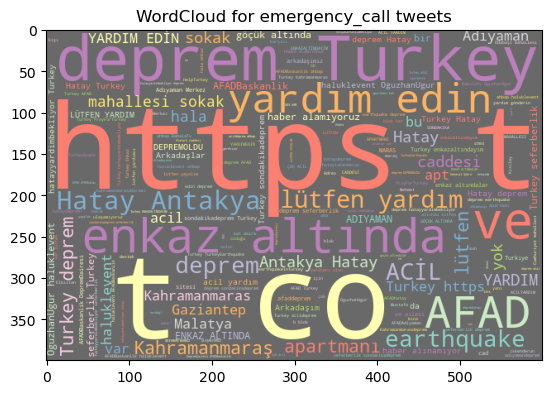

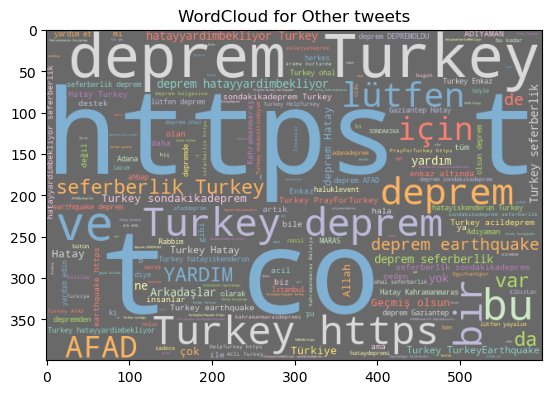

In [17]:
for label in set(df['label']):
    #print("WordCloud for", i)
    words = ''
    for document in df[df['label'] == label]['text']:
        words += document + ' '
    wordcloud = WordCloud(width=600, height=400, background_color='#696969', colormap='Set3').generate(words)
    plt.imshow(wordcloud)
    plt.title("WordCloud for {} tweets".format(label))
    plt.show()

At a first glance, there does not seem to be much differentiation between two cateories, as the most frequent words are obviously url links, hashtags, tags obviously. Let's generate the wordclouds again after text cleaning.

### Data Cleaning 
Social media data is known to be more challening for algorithms since they are far from official and standardized uses of language with a lot of typos, abbreviations, slangs and emojis! So the first job is to try to make the text as understandable as possible for the algorithm. To this end:
- I will remove emojis and special characters
- I will also remove hashtags(#-) and person tags (@-) since I observed them to be present in evrey tweet regardless of the content. To be specific the hashtag '#enkazaltında" which translates as 'under the rubbles' were added to every tweet even it was not about a help call.
- Another issue is the frequent abbreviations that were used to refer to the places or addresses. There are more too many different ways to refer to the epicenter of the earthquake for example (Kahramanmaraş, KMaraş, Maraş...) Even though the abbreviation is not necessarily a hard challenge for complex ML algorithms like Transformers, they can be misleading for the simpler models. Therefore I will standardize them as best as I can since addresses are literally the most crucial part in our data.
- I will make sure that special turkish letters like I is lowcased properly (it should become ı, not i).
- Finally I will adjust spaces.


In [20]:
corpus = ' '.join(df['text'])
unique_char = set(re.findall(r'.', corpus)) #gives all characters, r'\w' gives alphanumerical
print(unique_char)

{'l', '↙', 'ج', '♥', '😕', '.', 'v', '📱', '🤍', '–', 'x', '♦', '🦾', ',', '|', '🐕', '👀', '©', 'N', '2', '_', '"', 'c', 'ı', 'μ', '`', 'ق', '💥', 'X', 'Z', 'З', 'я', 'ا', '❤', 'I', 'ü', 'ñ', 'с', '♾', '🕯', 'E', '💢', 'з', ')', '🏿', '🥲', '±', 'ç', '🗨', '🇪', 'n', '”', 'ù', '🕊', '𝗬', ']', '🥴', '❞', '🇺', 'J', '‚', '😿', '•', 'î', 'ṣ', 'ظ', '🇰', '😒', '⏺', '🫀', 'Î', '☎', '😍', 'Ş', '⏬', '😶', '⬇', '💭', '°', 'f', 'ه', ' ', 'Ü', '🤦', '😳', '🇵', '?', '🏾', '🤚', 'ر', '𝗞', '☝', 'a', '🙁', '✴', '⁰', '😓', '😨', '5', '👋', '💟', 'Ç', 'ب', '\u202f', '𝕚', 'ﷻ', '💔', '💐', '𝕫', '𝕕', '𝕝', 'Y', 'y', '🤐', '💯', 'z', '🌹', '📵', ':', 'ى', '🇩', '⛈', 'á', '🧿', 'G', '❝', 'P', '처', 'h', 'j', '’', 'p', '\xa0', '🚑', 'ι', 't', 'Τ', 'Ğ', 'u', '[', '#', 'ķ', '𝕞', '😡', '/', '👉', '𝕒', '🛑', 'U', 'ş', '🤝', '🟧', '😌', 'ê', 'ہ', '𝗟', 'أ', "'", '3', '👏', '👁', '⚡', 'ș', 'í', '💪', '🔻', '🥀', '\U0001f979', 'd', '𝕐', '◊', '🐾', '𝗔', '❌', '\U0001faf1', '￼', '📢', '—', '+', 'i', '🐺', '✅', '⚠', '𝗜', '💚', 'ت', '~', '💕', '\U0001faf6', 'Ź', '⚫', 'ص', '📸',

In [21]:
abbreviations = [
    ('apt', 'Apartmanı'),
    ('Apt', 'Apartmanı'),
    ('APT', 'Apartmanı'),
    ('apart', 'Apartmanı'),
    ('Apart', 'Apartmanı'),
    ('APART', 'Apartmanı'),
    ('sok', 'Sokak'),
    ('sk', 'Sokak'),
    ('Sok', 'Sokak'),
    ('Sk', 'Sokak'),
    ('SOK', 'Sokak'),
    ('SK', 'Sokak'),
    ('cad', 'Caddesi'),
    ('Cad', 'Caddesi'),
    ('CAD', 'Caddesi'),
    ('cd', 'Caddesi'),
    ('Cd', 'Caddesi'),
    ('CD', 'Caddesi'),
    ('bşk', 'başkanlığı'),
    ('bul', 'Bulvarı'),
    ('blv', 'Bulvarı'),
    ('Blv', 'Bulvarı'),
    ('BLV', 'Bulvarı'),
    ('bulv', 'Bulvarı'),
    ('Bulv', 'Bulvarı'),
    ('BULV', 'Bulvarı'),
    ('mey', 'meydanı'),
    ('meyd', 'meydanı'),
    ('ecz', 'Eczanesi'),
    ('Ecz', 'Eczanesi'),
    ('ECZ', 'Eczanesi'),
    ('mh', 'Mahallesi'),
    ('mah', 'Mahallesi'),
    ('Mh', 'Mahallesi'),
    ('Mah', 'Mahallesi'),
    ('MH', 'Mahallesi'),
    ('MAH', 'Mahallesi'),
    ('şb', 'şube'),
    ('maraş', 'Kahramanmaraş'),
    ('maras', 'Kahramanmaraş'),
    ('Maraş', 'Kahramanmaraş'),
    ('Maras', 'Kahramanmaraş'),
    ('MARAŞ', 'Kahramanmaraş'),
    ('MARAS', 'Kahramanmaraş'),
    ('kmaraş', 'Kahramanmaraş'),
    ('kmaras', 'Kahramanmaraş'),
    ('KMaraş', 'Kahramanmaraş'),
    ('KMaras', 'Kahramanmaraş'),
    ('KMARAŞ', 'Kahramanmaraş'),
    ('KMARAS', 'Kahramanmaraş'),
    ('antep', 'Gaziantep'),
    ('Antep', 'Gaziantep'),
    ('ANTEP', 'Gaziantep'),
    ('anteb', 'Gaziantep'),
    ('Anteb', 'Gaziantep'),
    ('ANTEB', 'Gaziantep'),
    ('Urfa', 'Şanlıuarfa'),
    ('urfa', 'Şanlıuarfa'),
    ('URFA', 'Şanlıuarfa'),

    ]

def normalize_abbreviations(text):
    for regex, replacement in abbreviations:
        text = re.sub(rf'\b{re.escape(regex)}\b', replacement, text)
        text = re.sub(r'\s\s+', ' ',text)
        text = text.replace('k.maraş', 'Kahramanmaraş')
        text = text.replace('K.maraş', 'Kahramanmaraş')
        text = text.replace('K.Maraş', 'Kahramanmaraş')
        text = text.replace('k.maras', 'kahramanmaraş')
        text = text.replace('K.maras', 'Kahramanmaraş')
        text = text.replace('K.Maras', 'kahramanmaraş')
    return text


In [22]:
def turkish_lowercase_conversion(text):
    # Replace Turkish "İ" with lowercase "i"
    text = text.replace("İ", "i")

    # Replace Turkish "ı" with uppercase "I"
    text = text.replace("I", "ı")

    # Convert the remaining text to lowercase
    text = text.lower()

    return text

text = 'ŞAZİBEY MAHALLESİ HAYDAR ALİYEV BULVARI YUNUS APARTMANI A BLOK ACİLEN EKİBE İHTİYACIMIZ VAR LÜTFEN SESİMİZİ DUYURUN YARDIM EDİN'
turkish_lowercase_conversion(text)


'şazibey mahallesi haydar aliyev bulvarı yunus apartmanı a blok acilen ekibe ihtiyacımız var lütfen sesimizi duyurun yardım edin'

In [23]:
#keep punctuation but make sure there are space after each or remove punctuation
#remove all tags, remove all links, remove all hashtags

def clean(text):
    clean_text = normalize_abbreviations(text)
    #remove all links:
    clean_text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    #remove all non-alphanumerical characters except @ and # while keeping special turkish letters: sçÇğĞıİöÖşŞüÜ@#
    clean_text = re.sub(r'[^\w\sçÇğĞıİöÖşŞüÜ@#]', ' ', clean_text)
    #remove any entity that follows @ and #
    i = 0
    while i < (len(clean_text)):
        if clean_text[i] == '@' or clean_text[i]== '#':
            a=0
            while i+a < len(clean_text):
                if clean_text[i+a] == ' ':
                    break
                else:
                    a += 1
            clean_text = clean_text[:i] + clean_text[i+a+1:]
        else:
            i+=1
    #conversion to lowercase, i noticed above that there is an issue with the conversion of letter I and letter İ:
    #so we'll have to go steop-by-step:
    clean_text = clean_text.replace("İ", "i")
    clean_text = clean_text.replace("I", "ı")
    clean_text = clean_text.lower()
    clean_text = re.sub(r'\s\s+', ' ', clean_text)
    return clean_text


In [24]:
df = df[['id','text','label']]
df['text'] = df['text'].apply(lambda x: clean(x))
df.head()

,id,text,label
0,46001,arama kurtarma ekipleri heryere yetişemiyor kı...,Other
1,46002,marketleri dükkanları ölmüş insanları yağmalay...,Other
2,46003,arkadaşlar böyle bir uygulama varmış ilaçları ...,Other
3,46004,adıyamanda destek yok çok fazla bina yıkıldı h...,Other
4,46005,turunçlu mahallesi samandag yolu uzeri saray m...,emergency_call


#### Now let's try out the wordclouds one more time.

In [28]:
stops = stopwords.words('turkish')

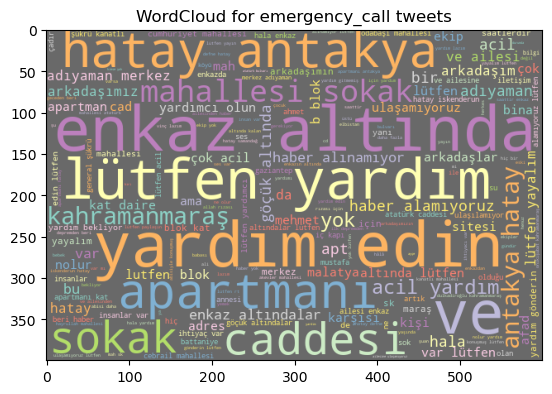

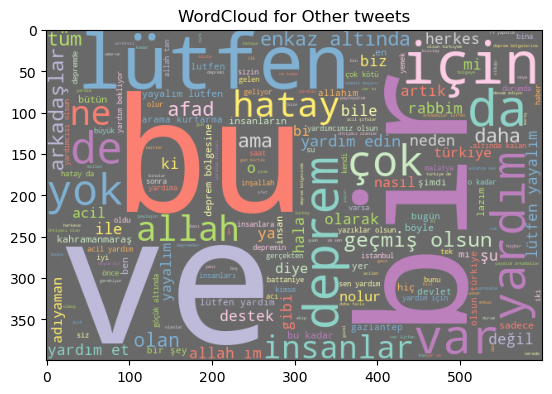

In [31]:
for label in set(df['label']):
    #print("WordCloud for", i)
    words = ''
    for document in df[df['label'] == label]['text']:
        words += document + ' '
    wordcloud = WordCloud(width=600, height=400, background_color='#696969', colormap='Set3').generate(words)
    plt.imshow(wordcloud)
    plt.title("WordCloud for {} tweets".format(label))
    plt.show()

This time the disctinction between two wordclouds is much more clear.
- The second image, which shows the most frequent words in tweets with the label 'Other', contains mostly the common stop words in Turkish such as "ve" (and), "bu" (this), "bir" (one/a/an), "çok" (much) as one can expect. Other most frequent words are "Allah" (God), "geçmiş olsun" (my condolences), "lütfen" (please), which also makes sense as these are mostly the tweets to share their condolences and pray for the people.
- On the other hand, the first image which shows the frequent words in the "emergency call" tweets are "lütfen" (please)," yardım / yardım edin" (help), "enkaz altında" (under the rubbles), "hatay / antakya" (one of the most affected cities), "mahallesi" (neighborhood), "sokak" / "caddesi" (street), "apartmanı" (building) which also makes sense since people who make emergency calls often share locations. Interestingly, in these tweets, these words were even more frequently used than typical stopwords.

### Text Preprocessing
- Before training the model, I will lastly convert the target variable to integers, tokenize the texts and represent them as vectors. 
- For vectorization I will first use the CountVectorizer(), however, I will explore and compare the performance of Tfidf vectors as well while tuning the hyperparameters of the models.

In [15]:
target_map = {'Other': 0, 'emergency_call': 1}
df['target'] = df['label'].map(target_map)

In [16]:
text_train, text_test, Y_train, Y_test = train_test_split(df['text'], df['target'], random_state = 42)

In [17]:
## tokenize the texts and turn them into vectors
stops = stopwords.words('turkish')
vectorizer = CountVectorizer(stop_words = None, max_features = None)
X_train = vectorizer.fit_transform(text_train)
X_test = vectorizer.transform(text_test)


## PART 2: MACHINE LEARNING

### 2.1 Logistic Regression

In [18]:
LR = LogisticRegression(max_iter = 500)
LR.fit(X_train, Y_train)


LogisticRegression(max_iter=500)

In [19]:
print("train score:", LR.score(X_train, Y_train))
print("test score:", LR.score(X_test, Y_test))

Ptrain = LR.predict(X_train)
Ptest = LR.predict(X_test)
print("train F1:", f1_score(Y_train, Ptrain))
print("test F1:", f1_score(Y_test, Ptest))


train score: 0.9893333333333333
test score: 0.9428
train F1: 0.9754751686082158
test F1: 0.8772532188841202


The basic regression model acheieved quite good accuracy levels in both sets. However, since we are dealing with a highly imbalanced dataset accuracy is not the most appropriate metric to evaluate the model. F1 score of the model on test set is 0.87, which is still decent.

#### Hyperparameter Tuning
Here not only will I apply grid search to find optimum parameters for the model but also for the preprocessor (i.e. count vectorizer vs tfidf).

In [22]:
pipe = Pipeline([
    ('c_vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=1000))])



parameters = {
    'c_vect__max_features': [2000, 5000, None],
    'c_vect__stop_words': [stops, None],
    'tfidf__use_idf': [True, False],
    'clf__C': np.logspace(-3,3,3),
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
}


LR_best = GridSearchCV(pipe,
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 10,
                           n_jobs = -1,)
                         # refit = 'recall')

    #burda recall'a refit yapıp ttüm scoreları eklesek nolur

LR_best.fit(text_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('c_vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'c_vect__max_features': [2000, 5000, None],
                         'c_vect__stop_words': [['acaba', 'ama', 'aslında',
                                                 'az', 'bazı', 'belki', 'biri',
                                                 'birkaç', 'birşey', 'biz',
                                                 'bu', 'çok', 'çünkü', 'da',
                                                 'daha', 'de', 'defa', 'diye',
                                                 'eğer', 'en', 'gibi', 'hem',
                                                 'hep', 'hepsi', 'her', 'hiç',
                                                 'için', 'ile', 'ise', 'kez', ...],
                                                None],
                         'clf__C': array([1.e-03, 1.e+00, 1.e+03]),
                         'tfidf__use_idf': [True, False]},
             scoring='recall')

In [42]:
LR_best.best_params_

{'c_vect__max_features': None,
 'c_vect__stop_words': None,
 'clf__C': 1000.0,
 'tfidf__use_idf': False}

In [43]:
P_test = LR_best.predict(text_test)
P_train = LR_best.predict(text_train)
print(classification_report(Y_test, P_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1858
           1       0.96      0.83      0.89       642

    accuracy                           0.95      2500
   macro avg       0.95      0.91      0.93      2500
weighted avg       0.95      0.95      0.95      2500



In [45]:
def plot_cm(ax, cm, title):
    classes = [0, 1]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    sns.heatmap(df_cm, annot=True, fmt='g', ax = ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")
    ax.set_title(title)


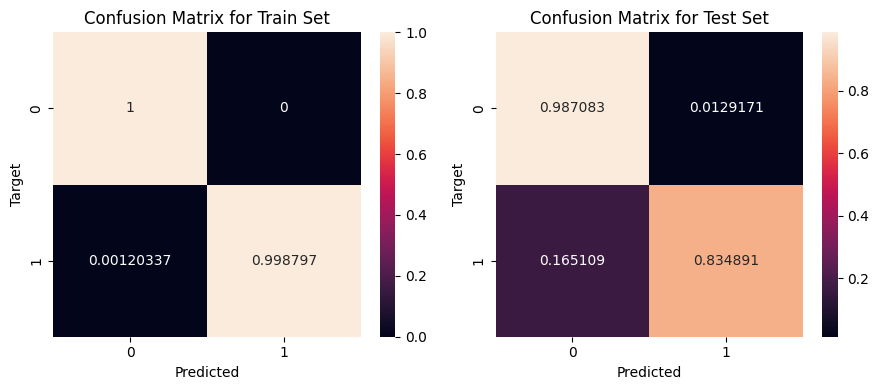

In [44]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
cm_test = confusion_matrix(Y_test, P_test, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

### 2.2 Naive Bayes Classifier

In [33]:
NB = MultinomialNB()
NB.fit(X_train, Y_train)

MultinomialNB()

In [34]:
print("train score:", NB.score(X_train, Y_train))
print("test score:", NB.score(X_test, Y_test))

Ptrain = NB.predict(X_train)
Ptest = NB.predict(X_test)
print("train F1:", f1_score(Y_train, Ptrain))
print("test F1:", f1_score(Y_test, Ptest))


train score: 0.9566666666666667
test score: 0.9324
train F1: 0.9069567706842256
test F1: 0.866614048934491


#### Hyperparameter tuning for Naive Bayes

In [35]:
pipe = Pipeline([
    ('c_vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=1000))])



parameters = {
    'c_vect__max_features': [2000, 5000, None],
    'c_vect__stop_words': [stops, None],
    'tfidf__use_idf': [True, False],
    'clf__C': np.logspace(-3,3,3),
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
}


NB_best = GridSearchCV(pipe,
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 10,
                           n_jobs = -1,)
                         # refit = 'recall')

    #burda recall'a refit yapıp ttüm scoreları eklesek nolur

NB_best.fit(text_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('c_vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'c_vect__max_features': [2000, 5000, None],
                         'c_vect__stop_words': [['acaba', 'ama', 'aslında',
                                                 'az', 'bazı', 'belki', 'biri',
                                                 'birkaç', 'birşey', 'biz',
                                                 'bu', 'çok', 'çünkü', 'da',
                                                 'daha', 'de', 'defa', 'diye',
                                                 'eğer', 'en', 'gibi', 'hem',
                                                 'hep', 'hepsi', 'her', 'hiç',
                                                 'için', 'ile', 'ise', 'kez', ...],
                                                None],
                         'clf__C': array([1.e-03, 1.e+00, 1.e+03]),
                         'tfidf__use_idf': [True, False]},
             scoring='recall')

In [39]:
NB_best.best_params_

{'c_vect__max_features': None,
 'c_vect__stop_words': None,
 'clf__C': 1000.0,
 'tfidf__use_idf': False}

In [45]:
P_test = NB_best.predict(text_test)
P_train = NB_best.predict(text_train)
print(classification_report(Y_test, P_test))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1858
           1       0.96      0.83      0.89       642

    accuracy                           0.95      2500
   macro avg       0.95      0.91      0.93      2500
weighted avg       0.95      0.95      0.95      2500



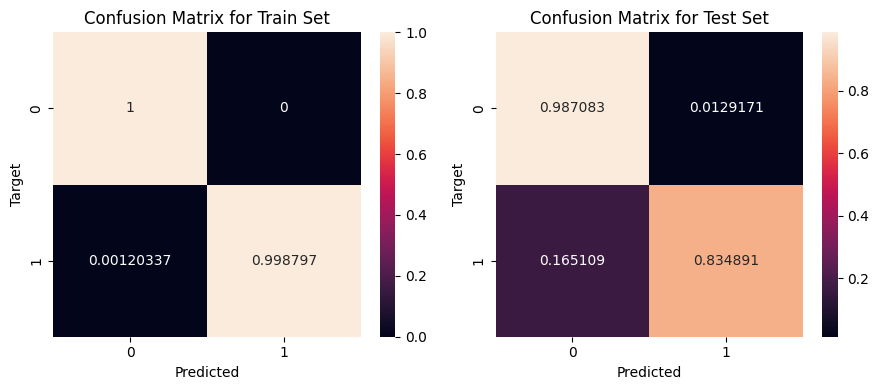

In [46]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
cm_test = confusion_matrix(Y_test, P_test, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

### 2.3 Support Vector Machine

In [47]:
SVM = SVC(kernel = "linear", random_state = 42, probability = True)
SVM.fit(X_train, Y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [48]:

print("train score:", SVM.score(X_train, Y_train))
print("test score:", SVM.score(X_test, Y_test))

Ptrain = SVM.predict(X_train)
Ptest = SVM.predict(X_test)
print("train F1:", f1_score(Y_train, Ptrain))
print("test F1:", f1_score(Y_test, Ptest))


train score: 0.998
test score: 0.938
train F1: 0.995475113122172
test F1: 0.8702928870292888


#### Hyperparameter tuning for SVM

In [51]:
X_sample = text_train.sample(n=1000, random_state=42)
Y_sample = Y_train.sample(n=1000, random_state=42)

In [52]:
pipe = Pipeline([
    ('c_vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC())])



parameters = [{
    'c_vect__max_features': [2000, 5000, None],
    'c_vect__stop_words': [stops, None],
    'tfidf__use_idf': [True, False],
    'clf__C': [0.25, 0.5, 0.75, 1],
    'clf__kernel' : ["linear"]},
    {'c_vect__max_features': [2000, 5000, None],
    'c_vect__stop_words': [stops, None],
    'tfidf__use_idf': [True, False],
    'clf__C': [0.25, 0.5, 0.75, 1],
    'clf__kernel' : ["rbf"],
    'clf__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]



SVM_best = GridSearchCV(pipe,
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 10,
                           n_jobs = -1,)
                         # refit = 'recall')
SVM_best.fit(X_sample, Y_sample)



GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('c_vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid=[{'c_vect__max_features': [2000, 5000, None],
                          'c_vect__stop_words': [['acaba', 'ama', 'aslında',
                                                  'az', 'bazı', 'belki', 'biri',
                                                  'birkaç', 'birşey', 'biz',
                                                  'bu', 'çok', 'çünkü', 'da',
                                                  'daha', 'de', 'defa', 'diye',
                                                  'eğer', 'en', 'gibi', '...
                          'c_vect__stop_words': [['acaba', 'ama', 'aslında',
                                                  'az', 'bazı', 'belki', 'biri',
                                                  'birkaç', 'birşey', 'biz',
                                                  'bu', 'çok', 'çünkü', 'da',
                                                  'daha', 'de', 'defa', 'diye',
                                                  'eğer', 'en', 'gibi', 'hem',
                                                  'hep', 'hepsi', 'her', 'hiç',
                                                  'için', 'ile', 'ise', 'kez', ...],
                                                 None],
                          'clf__C': [0.25, 0.5, 0.75, 1],
                          'clf__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                         0.9],
                          'clf__kernel': ['rbf'],
                          'tfidf__use_idf': [True, False]}],
             scoring='recall')

In [54]:
SVM_best.best_params_

{'c_vect__max_features': 5000,
 'c_vect__stop_words': ['acaba',
  'ama',
  'aslında',
  'az',
  'bazı',
  'belki',
  'biri',
  'birkaç',
  'birşey',
  'biz',
  'bu',
  'çok',
  'çünkü',
  'da',
  'daha',
  'de',
  'defa',
  'diye',
  'eğer',
  'en',
  'gibi',
  'hem',
  'hep',
  'hepsi',
  'her',
  'hiç',
  'için',
  'ile',
  'ise',
  'kez',
  'ki',
  'kim',
  'mı',
  'mu',
  'mü',
  'nasıl',
  'ne',
  'neden',
  'nerde',
  'nerede',
  'nereye',
  'niçin',
  'niye',
  'o',
  'sanki',
  'şey',
  'siz',
  'şu',
  'tüm',
  've',
  'veya',
  'ya',
  'yani'],
 'clf__C': 1,
 'clf__kernel': 'linear',
 'tfidf__use_idf': True}

In [56]:
P_test = SVM_best.predict(text_test)
P_train = SVM_best.predict(text_train)
print(classification_report(Y_test, P_test))


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1858
           1       0.95      0.70      0.81       642

    accuracy                           0.91      2500
   macro avg       0.93      0.85      0.88      2500
weighted avg       0.92      0.91      0.91      2500



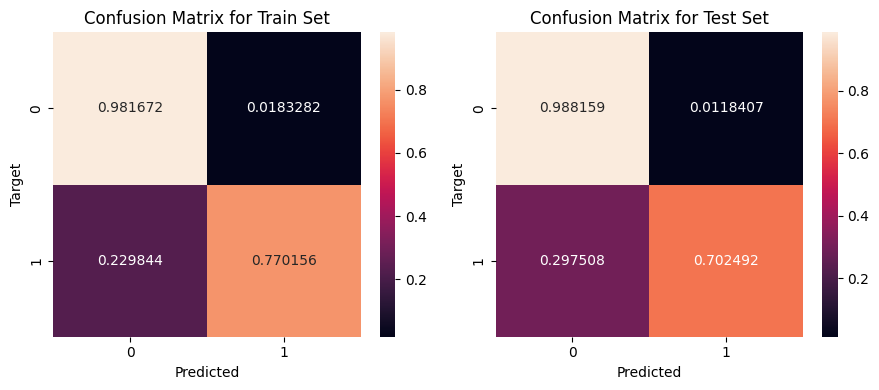

In [59]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
cm_test = confusion_matrix(Y_test, P_test, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

### 2.4 Recurrent Neural Networks : LSTM

In [60]:
df['targets'] = df['label'].astype("category").cat.codes
K = df['targets'].max() + 1

In [77]:
X_tv, X_test, Y_tv, Y_test = train_test_split(df['text'], df['target'], test_size = 1000, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_tv,Y_tv, random_state = 42)

In [78]:
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

word2idx = tokenizer.word_index
V = len(word2idx)
print('Number of unique tokens:', V)

Number of unique tokens: 21169


In [79]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

data_val = pad_sequences(sequences_val, maxlen =T)
print('Shape of data validation tensor:', data_val.shape)

Shape of data train tensor: (6750, 38)
Shape of data test tensor: (1000, 38)
Shape of data validation tensor: (2250, 38)


In [89]:
D = 30
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
#x = LSTM(8, return_sequences=True)(x)
x = LSTM(8, return_sequences=False)(x)
#x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)

model = Model(i, x)

In [90]:
# Compile and fit
model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print('Training model...')
r = model.fit(
  data_train,
  Y_train,
  epochs=10,
  validation_data=(data_val, Y_val),
  batch_size=128,
)

Training model...
Epoch 1/10
53/53 [==============================] - 6s 52ms/step - loss: 0.5958 - accuracy: 0.7702 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 0.4178 - val_accuracy: 0.7800 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/10
53/53 [==============================] - 2s 29ms/step - loss: 0.3357 - accuracy: 0.7941 - precision_6: 1.0000 - recall_6: 0.1038 - val_loss: 0.2605 - val_accuracy: 0.8564 - val_precision_6: 0.9886 - val_recall_6: 0.3515
Epoch 3/10
53/53 [==============================] - 2s 30ms/step - loss: 0.2203 - accuracy: 0.8950 - precision_6: 0.9817 - recall_6: 0.5532 - val_loss: 0.2040 - val_accuracy: 0.9178 - val_precision_6: 0.9586 - val_recall_6: 0.6545
Epoch 4/10
53/53 [==============================] - 2s 30ms/step - loss: 0.1681 - accuracy: 0.9404 - precision_6: 0.9542 - recall_6: 0.7782 - val_loss: 0.1789 - val_accuracy: 0.9364 - val_precision_6: 0.9444 - val_recall_6: 0.7556
Epoch 5/10
53/53 [========================

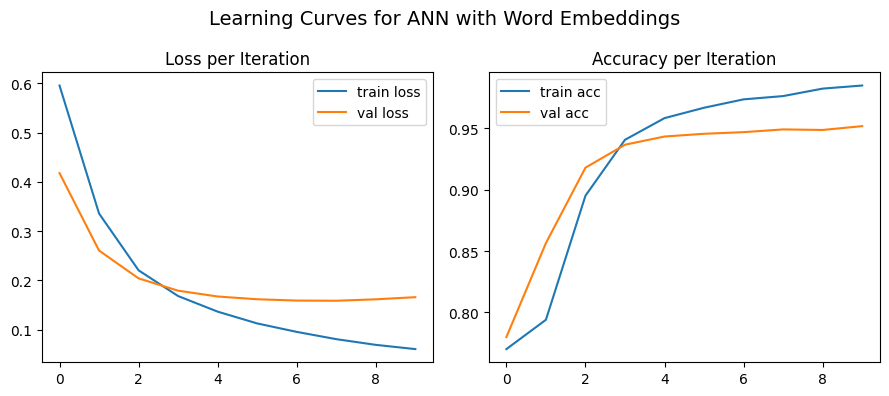

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plot loss per iteration on the first subplot (index 0)
ax[0].plot(r.history['loss'], label='train loss')
ax[0].plot(r.history['val_loss'], label='val loss')
ax[0].set_title('Loss per Iteration')
ax[0].legend()

# Plot accuracy per iteration on the second subplot (index 1)
ax[1].plot(r.history['accuracy'], label='train acc')
ax[1].plot(r.history['val_accuracy'], label='val acc')
ax[1].set_title('Accuracy per Iteration')
ax[1].legend()

fig.suptitle('Learning Curves for ANN with Word Embeddings', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [92]:
model.save('LSTM_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [93]:
P_train = ((model.predict(data_train) > 0) * 1.0).flatten()
P_val = ((model.predict(data_val) > 0) * 1.0).flatten()
P_test = ((model.predict(data_test) > 0) * 1.0).flatten()

print("Train acc:", accuracy_score(Y_train, P_train))
print("Train acc:", accuracy_score(Y_val, P_val))
print("Test acc:", accuracy_score(Y_test, P_test))

print("Train F1:", f1_score(Y_train, P_train))
print("Train F1:", f1_score(Y_val, P_val))
print("Test F1:", f1_score(Y_test, P_test))

32/32 [==============================] - 0s 4ms/step
Train acc: 0.9888888888888889
Train acc: 0.9506666666666667
Test acc: 0.945
Train F1: 0.9756888168557535
Train F1: 0.8849740932642487
Test F1: 0.8879837067209776


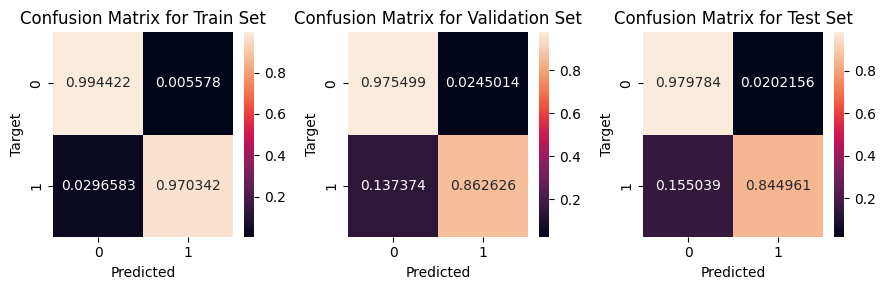

In [94]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
cm_val = confusion_matrix(Y_val, P_val, normalize='true')
cm_test = confusion_matrix(Y_test, P_test, normalize='true')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_val, title='Confusion Matrix for Validation Set')
plot_cm(axes[2], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

In [96]:
D = 30
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)


x = Bidirectional(LSTM(8, return_sequences=False))(x)

x = Dense(1)(x)

model_2 = Model(i, x)

# Compile and fit
model_2.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


print('Training model...')
r = model_2.fit(
  data_train,
  Y_train,
  epochs=8,
  validation_data=(data_val, Y_val),
  batch_size=128,
)

Training model...
Epoch 1/8
53/53 [==============================] - 9s 63ms/step - loss: 0.5687 - accuracy: 0.7702 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 0.4418 - val_accuracy: 0.7800 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/8
53/53 [==============================] - 2s 39ms/step - loss: 0.3520 - accuracy: 0.7738 - precision_8: 1.0000 - recall_8: 0.0155 - val_loss: 0.2711 - val_accuracy: 0.8316 - val_precision_8: 0.9915 - val_recall_8: 0.2364
Epoch 3/8
53/53 [==============================] - 2s 39ms/step - loss: 0.2118 - accuracy: 0.9104 - precision_8: 0.9566 - recall_8: 0.6389 - val_loss: 0.1878 - val_accuracy: 0.9364 - val_precision_8: 0.9000 - val_recall_8: 0.8000
Epoch 4/8
53/53 [==============================] - 2s 42ms/step - loss: 0.1455 - accuracy: 0.9511 - precision_8: 0.9414 - recall_8: 0.8395 - val_loss: 0.1692 - val_accuracy: 0.9422 - val_precision_8: 0.8908 - val_recall_8: 0.8404
Epoch 5/8
53/53 [=============================

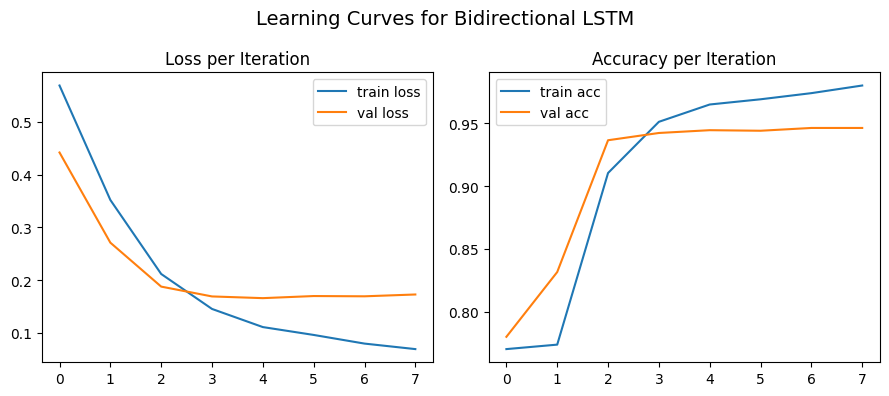

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plot loss per iteration on the first subplot (index 0)
ax[0].plot(r.history['loss'], label='train loss')
ax[0].plot(r.history['val_loss'], label='val loss')
ax[0].set_title('Loss per Iteration')
ax[0].legend()

# Plot accuracy per iteration on the second subplot (index 1)
ax[1].plot(r.history['accuracy'], label='train acc')
ax[1].plot(r.history['val_accuracy'], label='val acc')
ax[1].set_title('Accuracy per Iteration')
ax[1].legend()

fig.suptitle('Learning Curves for Bidirectional LSTM', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [99]:
model_2.save('LSTM_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [101]:
P_train = ((model_2.predict(data_train) > 0) * 1.0).flatten()
P_val = ((model_2.predict(data_val) > 0) * 1.0).flatten()
P_test = ((model_2.predict(data_test) > 0) * 1.0).flatten()

print("Train acc:", accuracy_score(Y_train, P_train))
print("Train acc:", accuracy_score(Y_val, P_val))
print("Test acc:", accuracy_score(Y_test, P_test))

print("Train F1:", f1_score(Y_train, P_train))
print("Train F1:", f1_score(Y_val, P_val))
print("Test F1:", f1_score(Y_test, P_test))

32/32 [==============================] - 0s 6ms/step
Train acc: 0.9835555555555555
Train acc: 0.9417777777777778
Test acc: 0.939
Train F1: 0.9643888354186718
Train F1: 0.8678102926337034
Test F1: 0.8782435129740518


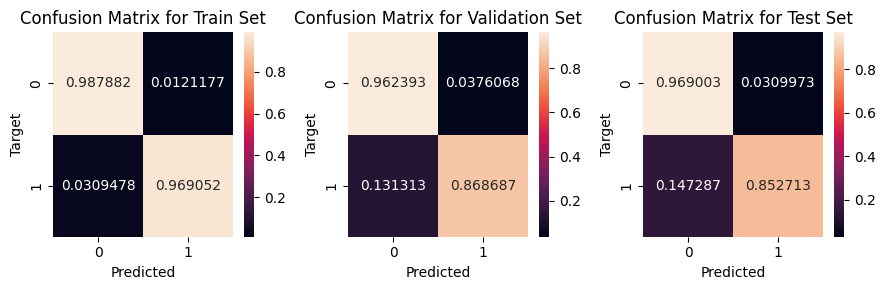

In [102]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
cm_val = confusion_matrix(Y_val, P_val, normalize='true')
cm_test = confusion_matrix(Y_test, P_test, normalize='true')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_val, title='Confusion Matrix for Validation Set')
plot_cm(axes[2], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

### 2.5 Transfer Learning : BERTÜRK

In [47]:
df_raw = pd.read_json('earthquake10K.json')
for i in range(len(df_raw)):
    a = df_raw['label'][i][0]
    df_raw.loc[i, 'label'] = a

df_raw.head()


,id,text,index,label,Comments
0,46001,Arama Kurtarma ekipleri heryere yetişemiyor kı...,108332,Other,[]
1,46002,"Marketleri, dükkanları, ölmüş insanları yağmal...",66352,Other,[]
2,46003,Arkadaşlar böyle bir uygulama varmış. İlaçları...,32462,Other,[]
3,46004,Adıyamanda destek yok. Çok fazla bina yıkıldı ...,84613,Other,[]
4,46005,"Turunçlu mahallesi samandag yolu uzeri, saray ...",22536,Rescue_call,[]


In [48]:
def merge_urgents(x):
  if x == 'Urgent_need' or x == 'Rescue_call':
    return 'emergency_call'
  else:
    return x
df_raw['label'] = df_raw['label'].apply(lambda x : merge_urgents(x))
set(df_raw['label'])

{'Other', 'emergency_call'}

In [49]:
target_map = {'Other': 0, 'emergency_call': 1}
df_raw['target'] = df_raw['label'].map(target_map)

In [108]:
df2 = df_raw[['text', 'target']]
df2.columns = ['sentence', 'label']
train_val_set, test_set = train_test_split(df2, test_size = 0.1, random_state = 123)
len(train_val_set)

9000

In [109]:
train_val_set.to_csv('data.csv', index=None)

In [110]:
raw_dataset = load_dataset('csv', data_files='data.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 9000
    })
})

In [111]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 6300
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2700
    })
})

In [112]:
checkpoint = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)
    #include truncation but not padding
    #padding will be automatically done by trainer

tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

In [113]:
bert_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
summary(bert_model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              24,576,000
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 11

In [115]:
training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=5, #5 epochs
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [116]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  prec = precision_score(labels, predictions)
  rec = recall_score(labels, predictions)
  return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}

In [117]:
trainer = Trainer(
    bert_model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [118]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.153478,0.944444,0.924015,0.830925,0.945724
2,0.180900,0.217776,0.949630,0.930594,0.848083,0.945724
3,0.066100,0.246705,0.955556,0.937819,0.875385,0.935855
4,0.015500,0.276915,0.952222,0.933486,0.863429,0.935855
5,0.015500,0.256507,0.961852,0.945371,0.914614,0.916118


TrainOutput(global_step=1970, training_loss=0.06751421472142796, metrics={'train_runtime': 792.6196, 'train_samples_per_second': 39.742, 'train_steps_per_second': 2.485, 'total_flos': 1719256024592400.0, 'train_loss': 0.06751421472142796, 'epoch': 5.0})

In [119]:
!ls training_dir

checkpoint-1182  checkpoint-1576  checkpoint-1970  checkpoint-394  checkpoint-788  runs


In [120]:
from transformers import pipeline
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-788',
                      device=0)

In [121]:
train_pred = savedmodel(split['train']['sentence'])
val_pred = savedmodel(split['test']['sentence'])
val_pred[:5]

[{'label': 'LABEL_0', 'score': 0.9998082518577576},
 {'label': 'LABEL_1', 'score': 0.9996515512466431},
 {'label': 'LABEL_0', 'score': 0.9951360821723938},
 {'label': 'LABEL_0', 'score': 0.9997878670692444},
 {'label': 'LABEL_1', 'score': 0.9976199269294739}]

In [122]:
def get_label(d):
  return int(d['label'].split('_')[1])
train_pred = [get_label(d) for d in train_pred]
val_pred = [get_label(d) for d in val_pred]

In [123]:
print("train acc:", accuracy_score(split['train']['label'], train_pred))
print("train f1:", f1_score(split['train']['label'], train_pred, average='macro'))
print("train prec:", precision_score(split['train']['label'], train_pred))
print("train rec:", recall_score(split['train']['label'], train_pred))


print("acc:", accuracy_score(split['test']['label'], val_pred))
print("f1:", f1_score(split['test']['label'], val_pred, average='macro'))
print("prec:", precision_score(split['test']['label'], val_pred))
print("rec:", recall_score(split['test']['label'], val_pred))

train acc: 0.9871428571428571
train f1: 0.9822771879068533
train prec: 0.9511082138200783
train rec: 0.9959044368600682
acc: 0.9496296296296296
f1: 0.9305939359664794
prec: 0.8480825958702065
rec: 0.9457236842105263


In [124]:
test_set.head()

,sentence,label
2656,Nasıl bu kadar çabuk rahatlıyoruz? #Erdogan #...,0
445,SUYA İHTİYAÇ VAR SU FİRMALARI SU GÖNDERİN 5 Lİ...,0
9505,3471 bina çökmüş. 1762 kişi vedat etmiş. Her b...,0
332,Malatyadayiz ve 200 e yakın bina yıkıldı kim b...,0
4168,Ahmet Batuhan Akdemir 22.06.2002 Hatay Belen ...,1


In [125]:
target = test_set['label']
sentences = test_set['sentence'].tolist()

In [126]:
test_pred = savedmodel(sentences)
test_pred = [get_label(d) for d in test_pred]

In [127]:
print("acc:", accuracy_score(target, test_pred))
print("f1:", f1_score(target, test_pred, average='macro'))
print("prec:", precision_score(target, test_pred, average=None))
print("rec:", recall_score(target, test_pred, average=None))

acc: 0.936
f1: 0.9127761181011361
prec: [0.97188755 0.83003953]
rec: [0.94408322 0.90909091]


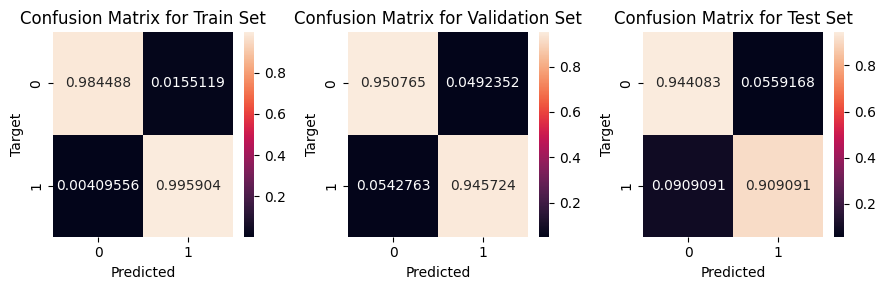

In [128]:
cm_train = confusion_matrix(split['train']['label'], train_pred, normalize='true')
cm_val = confusion_matrix(split['test']['label'], val_pred, normalize='true')
cm_test = confusion_matrix(target, test_pred, normalize='true')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_val, title='Confusion Matrix for Validation Set')
plot_cm(axes[2], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

## PART 3 : MODEL SELECTION

- Although Logistic Regression, as well as LSTM models achieved impressive performances in accuracy and F1 scores, confusion matrices show us that fine-tuned BERTURK model clearly outperformed all models especially in terms of recall score.
- Despite high accuracy and decent f1, other models (except for SVM which had the poorest performance) performed weak on the recall metric (between 0.83-0.86), which is the most important metric for this project.
- Recall score is a metric that shows how much of the relevant instances are retrieved, that is :
    True Positives / (False Negatives + True Positives) . In this context, it shows us what percentage of the emergency call tweets was actually detected by an algorithm.
- There is usually a trade-off between precision and recall, precision showing how much of the retrieved instances is actually relevant (what percentage of the tweets classified as "emergency" was in fact an emergency.

- There might be examples where precision can be a more relevant metric than recall, where we can take the risk of false negatives because false positives can pose actually a much bigger problem.
- Yet this example is a case where false negatives cannot be risked, as the misclassification of an emergency tweet as "other" can have fatal consequences. False positives is much less of a problem as we would not lose much if we wrongly think a tweet is emergency and pin it on our map, since there are still be users reading the tweets on the map.

- Therefore, I decided the good performance of transformers model on all scores, and over 5% improvement it offers on the recall score, completely justifies the computational cost and complexity arising due to GPU-intensive computation of transformers since stakes are HUMAN LIVES.


## PART 4: MODEL DEPLOYMENT
Since I ran the project on Colab but not on my local machine, this step will require one last package to import:

In [129]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [131]:
BERT_finetuned = savedmodel
path = F"/content/gdrive/MyDrive/{BERT_finetuned}"
torch.save(bert_model.state_dict(), path)

In [132]:
savedmodel.save_pretrained("bert-earthquake-tweets-classification")
tokenizer.save_pretrained("bert-earthquake-tweets-classification")

('bert-earthquake-tweets-classification/tokenizer_config.json',
 'bert-earthquake-tweets-classification/special_tokens_map.json',
 'bert-earthquake-tweets-classification/vocab.txt',
 'bert-earthquake-tweets-classification/added_tokens.json',
 'bert-earthquake-tweets-classification/tokenizer.json')

In [133]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [135]:
!huggingface-cli login
!huggingface-cli repo create berturk-earthquake-tweets-classification


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-crede

In [136]:
!git clone https://huggingface.co/yhaslan/berturk-earthquake-tweets-classification

Cloning into 'berturk-earthquake-tweets-classification'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), 422 bytes | 422.00 KiB/s, done.


In [139]:
!cd berturk-earthquake-tweets-classification
!echo "Hello!" >> README.md
!git add . && git commit -m "Update from $USER"

fatal: not a git repository (or any of the parent directories): .git


In [141]:
savedmodel.save_pretrained("path/to/repo/clone/berturk-earthquake-tweets-classification")
tokenizer.save_pretrained("path/to/repo/clone/berturk-earthquake-tweets-classification")

('path/to/repo/clone/berturk-earthquake-tweets-classification/tokenizer_config.json',
 'path/to/repo/clone/berturk-earthquake-tweets-classification/special_tokens_map.json',
 'path/to/repo/clone/berturk-earthquake-tweets-classification/vocab.txt',
 'path/to/repo/clone/berturk-earthquake-tweets-classification/added_tokens.json',
 'path/to/repo/clone/berturk-earthquake-tweets-classification/tokenizer.json')

In [142]:
huggingface_hub.upload_folder(folder_path='training_dir/checkpoint-788',
    repo_id="yhaslan/berturk-earthquake-tweets-classification",
    repo_type="model"
)

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/885M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

'https://huggingface.co/yhaslan/berturk-earthquake-tweets-classification/tree/main/'